In [2]:
#coding:utf8
import os
from PIL import Image
from torch.utils import data
import numpy as np
from torchvision import  transforms as T
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import *
from torch.utils import data
from torchvision import transforms
from torchvision.models import vgg16
import torch.nn as nn
import datetime

# dog=1,cat=0

# 加载数据集先定义自己的数据集

In [3]:
class DogCat(data.Dataset):
    def __init__(self,root,transforms=None,train=True,test=False):
        self.test = test
        imgs = [os.path.join(root,img) for img in os.listdir(root)] 
        # test1: data/test1/8973.jpg
        # train: data/train/cat.10004.jpg 
        if self.test:
            imgs = sorted(imgs,key=lambda x:int(x.split('.')[-2].split('\\')[-1]))
        else:
            imgs = sorted(imgs,key=lambda x:int(x.split('.')[-2]))  
        imgs_num = len(imgs)
        # shuffle imgs
        np.random.seed(100)
        
        self.imgs = imgs

        if transforms is None:
            if self.test or not train: 
                self.transforms = T.Compose([
                    T.CenterCrop(224),     #T.RandomResizedCrop(n)将给定图像随机裁剪为不同的                          
                    T.ToTensor(),                #比例，然后缩放所裁剪得到的图像为制定的大小
                    T.Normalize(mean = [0.485, 0.456, 0.406], 
                                     std = [0.229, 0.224, 0.225])
                    ]) 
            else :
                imgs = np.random.permutation(imgs)
                self.transforms = T.Compose([
                    T.CenterCrop(224),
                    T.RandomHorizontalFlip(),
                    T.ToTensor(),
                    T.Normalize(mean = [0.485, 0.456, 0.406], 
                                     std = [0.229, 0.224, 0.225])
                    ])  
    def __getitem__(self,index):
        '''
        一次返回一张图片的数据
        '''
        img_path = self.imgs[index]
        if self.test: label = int(self.imgs[index].split('.')[-2].split('\\')[-1])
        else: label = 1 if 'dog' in img_path.split('\\')[-1] else 0
        data = Image.open(img_path)
        data = self.transforms(data)
        return data, label    
    def __len__(self):
        return len(self.imgs)


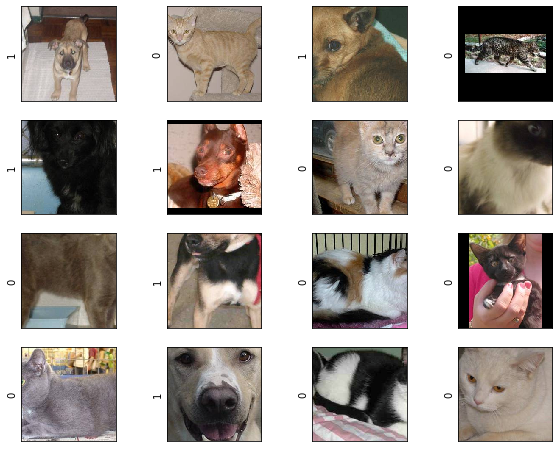

In [4]:
path = r'C:\Users\caeit\Desktop\binru7_1\train'
train_data = DogCat(path,train=True)
train_dataloader = DataLoader(train_data,batch_size=16,shuffle=True)
x,y = next(iter(train_dataloader))
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

plt.figure(figsize=(10,8))
for j,i in enumerate(x):
    i = torch.transpose(i,2, 0)
    i = torch.transpose(i,0, 1)
    plt.subplot(4,4,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(y.data.numpy()[j])
    plt.imshow(i*std+mean)

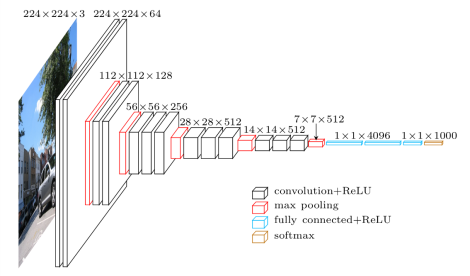

# 微调

In [7]:
from torchsummary import summary
model = vgg16(pretrained=False)
model.classifier[0] = nn.Linear(25088,512,bias=True)
model.classifier[3] = nn.Linear(512,512,bias=True)
model.classifier[4] = nn.Sigmoid()
model.classifier[6] = nn.Linear(in_features=512, out_features=2, bias=True)
model = model.cuda()

* 微调之后模型

In [8]:
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [9]:
cost = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.classifier.parameters(),lr=1e-4,momentum=0.9)

start = datetime.datetime.now()
for i in range(20):
        correct = 0.0
        total = 25000
        running_loss = 0.0
        accuracy = 0.0
        print('-----epoch', i+1, '-----')
        for num, image in enumerate(train_dataloader):
            x_train, y_train = image
            x_train = x_train.cuda()
            y_train = y_train.cuda()
            optimizer.zero_grad()
            output = model(x_train)
            loss = cost(output, y_train)
            _, predicted = torch.max(output, 1)
            correct += (predicted == y_train).sum().item()
            #print(correct)
            if num%100 == 0:
                print(num*16, '/ 25000', 'loss:', running_loss, ',accuracy:{}%'.format((100*correct/25000)),'correct:%s'%correct)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print('-----------Epoch:', i+1, ', one_epoch_loss:', running_loss, '-----------',',accuracy:%f'%(100*correct/25000))
print(datetime.datetime.now()-start)
torch.save(model, '../fine_tuning_20_epoch_dog_cat_vgg16.pkl')

# 测试12500张图片，提交到kaggle看结果

In [15]:
model = torch.load(r'C:\Users\caeit\Desktop\fine_tuning_20_epoch_dog_cat_vgg16.pkl')
model = model.cuda()

path = r'C:\Users\caeit\Desktop\binru7_1\test1'
test_data = DogCat(path,train=False,test=True)
test_dataloader = DataLoader(test_data,batch_size=16,shuffle=False,num_workers=0)

result = []
start = datetime.datetime.now()
for num, image in enumerate(test_dataloader):
    x_train, y_train = image
    x_train = x_train.cuda()
    y_train = y_train.cuda()

    output = model(x_train)

    _, predicted = torch.max(output, 1)
    result.append(predicted)
print(datetime.datetime.now()-start)
result1 = []
for i in result:
    i = i.cpu()
    for j in i.data.numpy():
        result1.append(j)
np.savetxt("vgg16.csv", result1, delimiter=',')

0:00:36.907093
